<a href="https://colab.research.google.com/github/1900690/Agro-Meteorological-Grid-Square-Data/blob/main/1km%E3%83%A1%E3%83%83%E3%82%B7%E3%83%A5%E6%B0%97%E8%B1%A1%E6%83%85%E5%A0%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#農研機構 メッシュ農業気象データシステムの使い方

1kmメッシュの気象データ作成の方法については以下の論文を参照

[実況値と数値予報，平年値を組み合わせたメッシュ気温・降水量データの作成](https://www.jstage.jst.go.jp/article/cib/16/0/16_J-16-028/_article/-char/ja/)

In [1]:
#@title 利用登録時に申請したIDとパスワードを入力
# ライブラリ（メッシュデータ処理のために必要）
!pip install -q netCDF4
!pip install -q japanize-matplotlib
import numpy as np
import os
import sys
import shutil
from google.colab import userdata
import japanize_matplotlib
from google.colab import files
japanize_matplotlib.japanize()
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr

ID = '' # @param {type:"string"}
passward = '' # @param {type:"string"}
if ID == '':
  ID= userdata.get("ID")
  passward= userdata.get("passward")

if os.path.exists('/content/AMGSDS_map.html'):
  os.remove('/content/AMGSDS_map.html')

!wget -q https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/releases/download/amd_tools4/amd_tools4.zip
!wget -q https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/releases/download/AMGSDS_map/AMGSDS_map.html

shutil.unpack_archive('/content/amd_tools4.zip')
os.remove('/content/amd_tools4.zip')
sys.path.append('/content/AMD_Tools4.py')#passを通す


path = "/content/AMD_Tools4.py"
line_num = 50 # 上書きする行番号(場合によっては変わる)
tempid = "USER='"+ID+"'\n" # 上書きしたい内容
temppass = "PASSWORDS=['"+passward+"','"+passward+"']\n" # 上書きしたい内容
font="plt.rcParams['font.family'] = 'Meiryo'\n"

with open(path) as file:
    list = file.readlines()
list[line_num] = tempid
list[line_num+1] = temppass
#list[line_num+38] = font
with open(path, mode="w") as file:
    file.writelines(list)


import AMD_Tools4 as amd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
#@title 調べる場所の経度と緯度を調べる（PCのみ）
#@markdown ←の➤を押してファイルをダウンロード、そのファイルを開き情報が欲しい区画の経度と緯度をコピーする

#@markdown ※スマホではマップアプリから経度緯度を取得すること
from google.colab import files
files.download('/content/AMGSDS_map.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<p align="center">
  <img src="https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/blob/main/%E8%AA%AC%E6%98%8E%E7%94%BB%E5%83%8F/%E5%BA%A7%E6%A8%99%E5%8F%96%E5%BE%97.png?raw=1" width=40%>
</p>

※スマホのマップでplus codeしか表示されない場合はplus codeを長押しでコピーし[ここ](https://poruruba.github.io/utilities/#:~:text=%E3%83%A6%E3%83%BC%E3%83%86%E3%82%A3%E3%83%AA%E3%83%86%E3%82%A3-,Geocoding,-Decode)へアクセスして、右上の"ユーティリティ"から”Geocoding”を選択して”pluscode”に張り付けして”Decode”ボタンを押して緯度経度を入手すること
<p align="center">
  <img src="https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/blob/main/%E8%AA%AC%E6%98%8E%E7%94%BB%E5%83%8F/plus%20code.png?raw=1" width=60%>
</p>

#1.日ごとの気象変化を折れ線グラフで表示


TMP_mea (28, 1, 1) Tile
Cli_TMP_mea (28, 1, 1) Tile


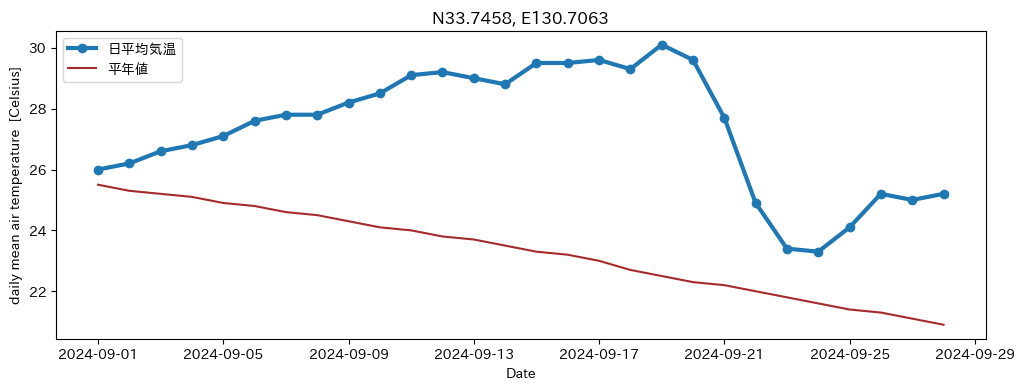

In [3]:
#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigou = [['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['1mm以上の降水の有無', 'OPR'], ['日照時間', 'SSD'], ['全天日射量', 'GSR'], ['下向き長波放射量', 'DLR'], ['日平均相対湿度', 'RH'], ['日平均風速', 'WIND'], ['積雪深', 'SD'], ['積雪相当水量', 'SWE'], ['日降雪相当水量', 'SFW'], ['予報気温の確からしさ', 'PTMP']]
#情報名を入力する
欲しい情報 = '日平均気温' # @param ["日平均気温", "日最高気温", "日最低気温", "降水量", "1mm以上の降水の有無", "日照時間", "全天日射量", "下向き長波放射量", "日平均相対湿度", "日平均風速", "積雪深", "積雪相当水量", "日降雪相当水量", "予報気温の確からしさ"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in yousokigou:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigou.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigou[j][1]

#@markdown ###期間の指定

#@markdown ※26日先までの予測が用意されているのは日平均気温、日最高気温、日最低気温、降水量、日照時間、予報気温の確からしさです。そのほかは９日先までの予測が用意されています
初め= '2024-09-01' # @param {type:"date"}
終わり = '2024-09-28' # @param {type:"date"}
itsu= [初め, 終わり]

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
緯度 = 33.7487 # @param {type:"number"}
経度 = 130.703 # @param {type:"number"}

doko= [緯度,緯度,経度,経度]

#@markdown ###平年値を取得するかどうか

#@markdown ※平年値がない値を選択するとエラーになります
平年値 = True # @param {type:"boolean"}
cli=平年値

# 設定に基づき気象データを取得
if cli==True:
  #設定に基づき気象データを取得
  data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)
  Ta = data[:,0,0]     #入れ物の入れ替え(3次元から1次元へ)
  #設定に基づき平年値を取得
  data,tim,lat,lon,nam,uni = amd.GetMetData(nani,itsu,doko,cli=True,namuni=True)  # 戻り値は6個になる
  Tn = data[:,0,0]   #入れ物の入れ替え(3次元から1次元へ)
  amd.linefig(tim, Ta,
      title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
      ylabel=f'{nam}  [{uni}]',
      llabel=欲しい情報,
      ref=Tn,
      filename="日別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png',
      llabelref='平年値')
else:
  data, tim, lat, lon,nam,uni = amd.GetMetData(nani, itsu, doko,namuni=True)
  Ta = data[:,0,0]     #入れ物の入れ替え(3次元から1次元へ)
  amd.linefig(tim, Ta,
      title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
      ylabel=f'{nam}  [{uni}]',
      llabel=欲しい情報,
      filename="日別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png',
      llabelref='平年値')

In [ ]:
#@title グラフをダウンロード
files.download("日別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title .CSVファイルでデータをダウンロード
# 列見出しの作成
dates = [d.strftime('%Y-%m-%d') for d in tim]
header = 'メッシュ値, 緯度, 経度, ' + ', '.join(dates)

# CSVファイルへの書き出し
amd.PutCSV_MT(data, lat, lon, addlalo=True, header=header, filename="日別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

files.download("日別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

#2.時間別の気象変化を折れ線グラフで表示

TMP (1465, 1, 1) Hourly


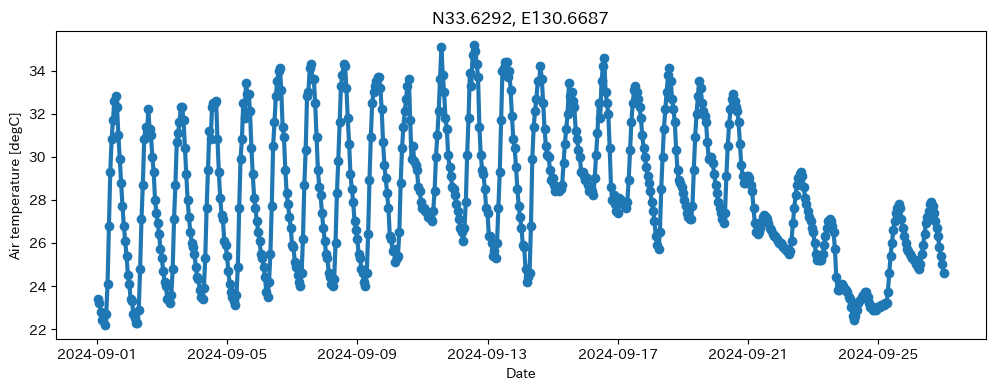

In [ ]:

#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigoutime = [['気温', 'TMP'], ['相対湿度', '%'], ['下向き長波放射', 'W/m2']]
#情報名を入力する
欲しい情報 = '気温' # @param ["気温", "相対湿度", "下向き長波放射"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in yousokigoutime:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigoutime.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigoutime[j][1]

#@markdown ###期間の指定

#@markdown ※９日先までの予測が用意されています
初め= '2024-09-01' # @param {type:"date"}
終わり = '2024-10-31' # @param {type:"date"}
itsu= [初め+'T01', 終わり+'T24']

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
緯度 = 33.6294 # @param {type:"number"}
経度 = 130.667 # @param {type:"number"}

doko= [緯度,緯度,経度,経度]


#設定に基づき気象データを取得
data, timh, lat, lon, nam, uni = amd.GetMetDataHourly(nani, itsu, doko, namuni=True)
Ta = data[:,0,0]     #入れ物の入れ替え(3次元から1次元へ)
#設定に基づき平年値を取得
Th = data[:,0,0]
lat_sc = lat[0]
lon_sc = lon[0]

amd.linefig(timh,Th,
         title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
         filename="時別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png',
         ylabel=f'{nam} [{uni}]')

In [ ]:
#@title グラフをダウンロード
files.download("時別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title .CSVファイルでデータをダウンロード
# 列見出しの作成
dates = [d.strftime('%Y-%m-%d-%H') for d in timh]
header = 'メッシュ値, 緯度, 経度, ' + ', '.join(dates)

# CSVファイルへの書き出し
amd.PutCSV_MT(data,lat,lon, addlalo=True, header=header, filename="時別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

files.download("時別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#3.温暖化シナリオデータの取得
メッシュ農業気象データでは全球気候モデルを用いた温暖化シナリオデータ(日別値)も３次メッシュで公開しています。詳しくは[「農研機構地域気候シナリオデータセット」の利用標準作業手順書](https://sop.naro.go.jp/document/detail/32)に説明があります。

Cli_TMP_min (365, 1, 1) Tile
TMP_min (365, 1, 1) Tile MIROC5 RCP8.5)


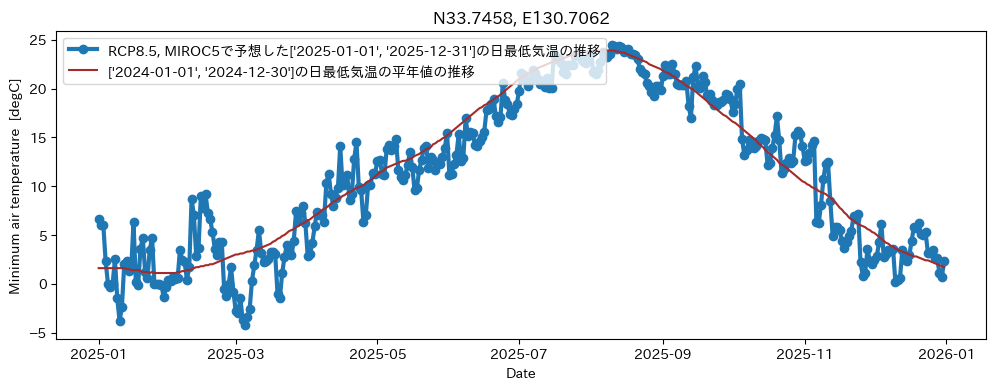

In [16]:
#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigouhist = [['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['全天日射量', 'GSR']]
欲しい情報 = '日最低気温' #@param ["日平均気温", "日最高気温", "日最低気温", "降水量", "全天日射量"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in yousokigouhist:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigouhist.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigouhist[j][1]

#@markdown ###比較する現在の期間の指定
初め現在= '2024-01-01' # @param {type:"date"}
終わり現在 = '2024-12-30' # @param {type:"date"}
itsu_now= [初め現在, 終わり現在]

#@markdown ###比較する未来の期間の指定
初め未来= '2025-01-01' # @param {type:"date"}
終わり未来 = '2025-12-31' # @param {type:"date"}
itsu_future= [初め未来, 終わり未来]

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
緯度 = 33.7487 # @param {type:"number"}
経度 = 130.703 # @param {type:"number"}

doko= [緯度,緯度,経度,経度]

#@markdown ###予測シナリオを選択
yosokusinario = [['4℃上昇シナリオ', 'RCP8.5'], ['2℃上昇シナリオ','RCP2.6']]
選択するシナリオ = '4℃上昇シナリオ' #@param ["4℃上昇シナリオ", "2℃上昇シナリオ"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in yosokusinario:
    if 選択するシナリオ in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yosokusinario.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
scenario = yosokusinario[j][1]

# 気象データの取得
model = 'MIROC5'

#@markdown ※予測に使用するモデルは'MIROC5'です。

#設定に基づき平年値を取得
data, tim, lat, lon = amd.GetMetData(nani, itsu_now, doko, cli=True)
Tmax = data[:,0,0]

# シナリオデータの取得
data, tim, lat, lon, nam, uni = amd.GetSceData(nani, itsu_future, doko, model, scenario, namuni=True)
Tsmax = data[:,0,0]

#設定に基づき平年値を取得
Th = data[:,0,0]
lat_sc = lat[0]
lon_sc = lon[0]

amd.linefig(tim, Tsmax,
      title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
      ylabel=f'{nam}  [{uni}]',
      llabel=f'{scenario}, {model}'+'で予想した'+str(itsu_future)+'の'+str(欲しい情報)+'の推移',
      filename="温暖化予測"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png',
      ref=Tmax,
      llabelref=str(itsu_now)+'の'+str(欲しい情報)+'の平年値の推移')

In [ ]:
#@title グラフをダウンロード
files.download("温暖化予測"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
#@title .CSVファイルでデータをダウンロード
# 列見出しの作成
dates = [d.strftime('%Y-%m-%d') for d in tim]
header = 'メッシュ値, 緯度, 経度, ' + ', '.join(dates)

# CSVファイルへの書き出し
amd.PutCSV_MT(data,lat,lon, addlalo=True, header=header, filename="温暖化予測"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

files.download("温暖化予測"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#4.メッシュデータの分布図を作成

データをシンプルな地図上の分布図として可視化します。

TMP_max (1, 120, 160) Tile


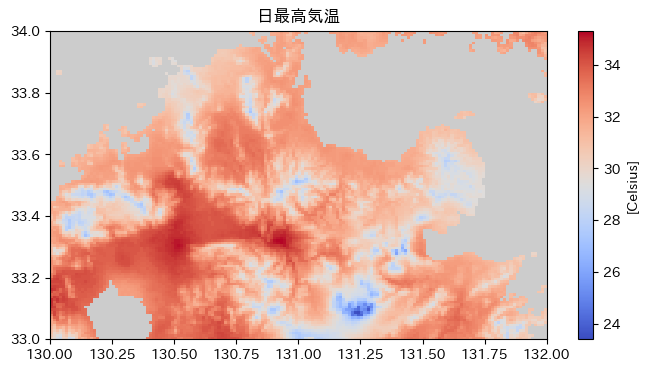

In [ ]:
#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigou = [['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['1mm以上の降水の有無', 'OPR'], ['日照時間', 'SSD'], ['全天日射量', 'GSR'], ['下向き長波放射量', 'DLR'], ['日平均相対湿度', 'RH'], ['日平均風速', 'WIND'], ['積雪深', 'SD'], ['積雪相当水量', 'SWE'], ['日降雪相当水量', 'SFW'], ['予報気温の確からしさ', 'PTMP']]
#情報名を入力する
欲しい情報 = '日最高気温' # @param ["日平均気温", "日最高気温", "日最低気温", "降水量", "1mm以上の降水の有無", "日照時間", "全天日射量", "下向き長波放射量", "日平均相対湿度", "日平均風速", "積雪深", "積雪相当水量", "日降雪相当水量", "予報気温の確からしさ"]
#リスト（情報名）の中から入力した都市名と一致するものを検索する
for i in yousokigou:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigou.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigou[j][1]

#@markdown ###期間の指定

#@markdown ※26日先までの予測が用意されているのは日平均気温、日最高気温、日最低気温、降水量、日照時間、予報気温の確からしさです。そのほかは９日先までの予測が用意されています
日付= '2024-09-01' # @param {type:"date"}
itsu= [日付, 日付]

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
小さいほうの緯度 = 33.0 # @param {type:"number"}
小さいほうの経度 = 130.0 # @param {type:"number"}
大きいほうの緯度 = 34.0 # @param {type:"number"}
大きいほうの経度 = 132.0 # @param {type:"number"}

doko= [小さいほうの緯度,大きいほうの緯度,小さいほうの経度,大きいほうの経度]

# 設定に基づき気象データを取得
data, tim, lat, lon, nam, uni = amd.GetMetData(nani, itsu, doko, namuni=True)
Ta = data[0,:,:]
amd.mapfig(Ta, lat, lon,
        #minmax=[-10,40],
        #figsize=[5,5],
        figtitle=str(欲しい情報),
        barlabel=f'[{uni}]',
        filename=欲しい情報+'.png',
        cmap='coolwarm')

In [ ]:
#@title 図をダウンロード
files.download(欲しい情報+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title .CSVファイルでデータをダウンロード
# 列見出しの作成
dates = [d.strftime('%Y-%m-%d') for d in tim]
header = 'メッシュ値, 緯度, 経度, ' + ', '.join(dates)

# CSVファイルへの書き出し
amd.PutCSV_MT(data,lat,lon, addlalo=True, header=header, filename=欲しい情報+'.csv')

files.download(欲しい情報+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title 地理院地図と重ね合わせて表示（pc用）
#@markdown ←の➤を押してファイルをダウンロード、その中の１つ **.html** をファイルをダブルクリックしてください。

amd.PutGSI_Map(Ta, lat, lon, filename=欲しい情報)

files.download(欲しい情報+'.html')
files.download(欲しい情報+'_l.png')
files.download(欲しい情報+'_o.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#5.県域地理情報を表示する

TMP_mea (1, 152, 94) Tile
pref_4000 (152, 94) Tile


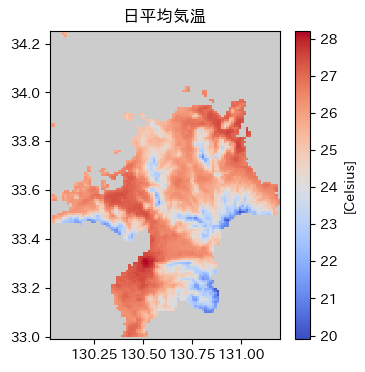

In [ ]:
#@title 県単位の気象データを表示
#県域記号一覧を作成
kenlist = [['北海道','pref_0100',[41.350,45.533,139.327,145.998]],
['青森県','pref_0200',[40.217,41.558,139.490,141.685]],
['岩手県','pref_0300',[38.742,40.458,140.652,142.073]],
['宮城県','pref_0400',[37.767,39.008,140.265,141.685]],
['秋田県','pref_0500',[38.867,40.517,139.690,140.998]],
['山形県','pref_0600',[37.733,39.217,139.515,140.648]],
['福島県','pref_0700',[36.783,37.983,139.165,141.048]],
['茨城県','pref_0800',[35.733,36.950,139.690,140.860]],
['栃木県','pref_0900',[36.192,37.158,139.327,140.298]],
['群馬県','pref_1000',[35.983,37.067,138.390,139.673]],
['埼玉県','pref_1100',[35.750,36.292,138.702,139.910]],
['千葉県','pref_1200',[34.892,36.108,139.740,140.885]],
['東京都','pref_1300',[34.675,35.900,138.940,139.923]],
['神奈川県','pref_1400',[35.125,35.675,138.915,139.835]],
['新潟県','pref_1500',[36.733,38.558,137.627,139.898]],
['富山県','pref_1600',[36.267,36.983,136.765,137.773]],
['石川県','pref_1700',[36.067,37.858,136.240,137.373]],
['福井県','pref_1800',[35.342,36.300,135.440,136.835]],
['山梨県','pref_1900',[35.167,35.975,138.177,139.135]],
['長野県','pref_2000',[35.192,37.033,137.315,138.748]],
['岐阜県','pref_2100',[35.133,36.467,136.277,137.660]],
['静岡県','pref_2200',[34.567,35.650,137.465,139.185]],
['愛知県','pref_2300',[34.567,35.425,136.665,137.848]],
['三重県','pref_2400',[33.717,35.258,135.852,136.998]],
['滋賀県','pref_2500',[34.783,35.708,135.765,136.460]],
['京都府','pref_2600',[34.700,35.783,134.852,136.060]],
['大阪府','pref_2700',[34.267,35.058,135.090,135.748]],
['兵庫県','pref_2800',[34.150,35.675,134.252,135.473]],
['奈良県','pref_2900',[33.858,34.783,135.540,136.235]],
['和歌山県','pref_3000',[33.425,34.392,135.002,136.023]],
['鳥取県','pref_3100',[35.050,35.617,133.127,134.523]],
['島根県','pref_3200',[34.300,36.358,131.665,133.398]],
['岡山県','pref_3300',[34.292,35.358,133.265,134.423]],
['広島県','pref_3400',[34.025,35.108,132.027,133.473]],
['山口県','pref_3500',[33.708,34.800,130.765,132.498]],
['徳島県','pref_3600',[33.533,34.258,133.652,134.823]],
['香川県','pref_3700',[34.008,34.567,133.440,134.448]],
['愛媛県','pref_3800',[32.883,34.308,132.002,133.698]],
['高知県','pref_3900',[32.700,33.892,132.477,134.323]],
['福岡県','pref_4000',[32.992,34.250,130.027,131.198]],
['佐賀県','pref_4100',[32.950,33.625,129.727,130.548]],
['長崎県','pref_4200',[31.983,34.733,128.102,130.398]],
['熊本県','pref_4300',[32.092,33.200,129.940,131.335]],
['大分県','pref_4400',[32.708,33.742,130.815,132.185]],
['宮崎県','pref_4500',[31.350,32.842,130.702,131.885]],
['鹿児島県','pref_4600',[28.750,32.317,128.965,131.210]],
['沖縄県','pref_4700',[24.042,27.892,122.927,131.335]]]
#情報名を入力する
#@markdown ###表示する県を選択
県= '福岡県' # @param ["北海道", "青森県", "岩手県", "宮城県", "秋田県", "山形県", "福島県", "茨城県", "栃木県", "群馬県", "埼玉県", "千葉県", "東京都", "神奈川県", "新潟県", "富山県", "石川県", "福井県", "山梨県", "長野県", "岐阜県", "静岡県", "愛知県", "三重県", "滋賀県", "京都府", "大阪府", "兵庫県", "奈良県", "和歌山県", "鳥取県", "島根県", "岡山県", "広島県", "山口県", "徳島県", "香川県", "愛媛県", "高知県", "福岡県", "佐賀県", "長崎県", "熊本県", "大分県", "宮崎県", "鹿児島県", "沖縄県"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in kenlist:
    if 県 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = kenlist.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
ken = kenlist[j][1]
doko = kenlist[j][2]



#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigou = [['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['1mm以上の降水の有無', 'OPR'], ['日照時間', 'SSD'], ['全天日射量', 'GSR'], ['下向き長波放射量', 'DLR'], ['日平均相対湿度', 'RH'], ['日平均風速', 'WIND'], ['積雪深', 'SD'], ['積雪相当水量', 'SWE'], ['日降雪相当水量', 'SFW'], ['予報気温の確からしさ', 'PTMP']]
#情報名を入力する
欲しい情報 = '日平均気温' # @param ["日平均気温", "日最高気温", "日最低気温", "降水量", "1mm以上の降水の有無", "日照時間", "全天日射量", "下向き長波放射量", "日平均相対湿度", "日平均風速", "積雪深", "積雪相当水量", "日降雪相当水量", "予報気温の確からしさ"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in yousokigou:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigou.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigou[j][1]

#@markdown ###期間の指定

表示する日付= '2024-09-01' # @param {type:"date"}
itsu= [表示する日付, 表示する日付]

# 設定に基づき気象データを取得
data, tim, lat, lon, nam, uni = amd.GetMetData(nani, itsu, doko, namuni=True)
Ta = data[0,:,:]

# 設定に基づき地理情報を取得
prf, lat, lon = amd.GetGeoData(ken, doko)

# 気象データを県域データでマスク
TaA = Ta * prf

# 図化
amd.mapfig(TaA, lat, lon,
        #minmax=[-10,40],
        #figsize=[5,5],
        figtitle=str(欲しい情報),
        barlabel=f'[{uni}]',
        filename=欲しい情報+'.png',
        cmap='coolwarm')

landuse_H210100 (152, 94) Tile
pref_4000 (152, 94) Tile


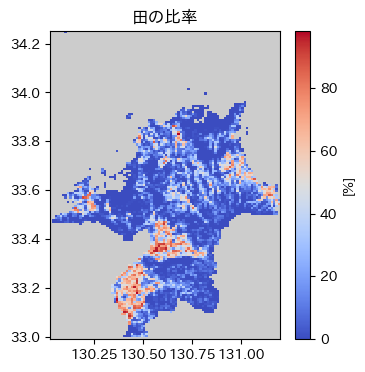

In [ ]:
#@title 県単位の土地利用比率を表示
#県域記号一覧を作成
kenlist = [['北海道','pref_0100',[41.350,45.533,139.327,145.998]],
['青森県','pref_0200',[40.217,41.558,139.490,141.685]],
['岩手県','pref_0300',[38.742,40.458,140.652,142.073]],
['宮城県','pref_0400',[37.767,39.008,140.265,141.685]],
['秋田県','pref_0500',[38.867,40.517,139.690,140.998]],
['山形県','pref_0600',[37.733,39.217,139.515,140.648]],
['福島県','pref_0700',[36.783,37.983,139.165,141.048]],
['茨城県','pref_0800',[35.733,36.950,139.690,140.860]],
['栃木県','pref_0900',[36.192,37.158,139.327,140.298]],
['群馬県','pref_1000',[35.983,37.067,138.390,139.673]],
['埼玉県','pref_1100',[35.750,36.292,138.702,139.910]],
['千葉県','pref_1200',[34.892,36.108,139.740,140.885]],
['東京都','pref_1300',[34.675,35.900,138.940,139.923]],
['神奈川県','pref_1400',[35.125,35.675,138.915,139.835]],
['新潟県','pref_1500',[36.733,38.558,137.627,139.898]],
['富山県','pref_1600',[36.267,36.983,136.765,137.773]],
['石川県','pref_1700',[36.067,37.858,136.240,137.373]],
['福井県','pref_1800',[35.342,36.300,135.440,136.835]],
['山梨県','pref_1900',[35.167,35.975,138.177,139.135]],
['長野県','pref_2000',[35.192,37.033,137.315,138.748]],
['岐阜県','pref_2100',[35.133,36.467,136.277,137.660]],
['静岡県','pref_2200',[34.567,35.650,137.465,139.185]],
['愛知県','pref_2300',[34.567,35.425,136.665,137.848]],
['三重県','pref_2400',[33.717,35.258,135.852,136.998]],
['滋賀県','pref_2500',[34.783,35.708,135.765,136.460]],
['京都府','pref_2600',[34.700,35.783,134.852,136.060]],
['大阪府','pref_2700',[34.267,35.058,135.090,135.748]],
['兵庫県','pref_2800',[34.150,35.675,134.252,135.473]],
['奈良県','pref_2900',[33.858,34.783,135.540,136.235]],
['和歌山県','pref_3000',[33.425,34.392,135.002,136.023]],
['鳥取県','pref_3100',[35.050,35.617,133.127,134.523]],
['島根県','pref_3200',[34.300,36.358,131.665,133.398]],
['岡山県','pref_3300',[34.292,35.358,133.265,134.423]],
['広島県','pref_3400',[34.025,35.108,132.027,133.473]],
['山口県','pref_3500',[33.708,34.800,130.765,132.498]],
['徳島県','pref_3600',[33.533,34.258,133.652,134.823]],
['香川県','pref_3700',[34.008,34.567,133.440,134.448]],
['愛媛県','pref_3800',[32.883,34.308,132.002,133.698]],
['高知県','pref_3900',[32.700,33.892,132.477,134.323]],
['福岡県','pref_4000',[32.992,34.250,130.027,131.198]],
['佐賀県','pref_4100',[32.950,33.625,129.727,130.548]],
['長崎県','pref_4200',[31.983,34.733,128.102,130.398]],
['熊本県','pref_4300',[32.092,33.200,129.940,131.335]],
['大分県','pref_4400',[32.708,33.742,130.815,132.185]],
['宮崎県','pref_4500',[31.350,32.842,130.702,131.885]],
['鹿児島県','pref_4600',[28.750,32.317,128.965,131.210]],
['沖縄県','pref_4700',[24.042,27.892,122.927,131.335]]]
#情報名を入力する
#@markdown ###表示する県を選択
県= '福岡県' # @param ["北海道", "青森県", "岩手県", "宮城県", "秋田県", "山形県", "福島県", "茨城県", "栃木県", "群馬県", "埼玉県", "千葉県", "東京都", "神奈川県", "新潟県", "富山県", "石川県", "福井県", "山梨県", "長野県", "岐阜県", "静岡県", "愛知県", "三重県", "滋賀県", "京都府", "大阪府", "兵庫県", "奈良県", "和歌山県", "鳥取県", "島根県", "岡山県", "広島県", "山口県", "徳島県", "香川県", "愛媛県", "高知県", "福岡県", "佐賀県", "長崎県", "熊本県", "大分県", "宮崎県", "鹿児島県", "沖縄県"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in kenlist:
    if 県 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = kenlist.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
ken = kenlist[j][1]
doko = kenlist[j][2]

#土地利用比率記号一覧を作成
youtilist = [['田','landuse_H210100'],
['その他の農用地','landuse_H210200'],
['森林','landuse_H210500'],
['荒地','landuse_H210600'],
['建物用地','landuse_H210700'],
['道路','landuse_H210901'],
['鉄道','landuse_H210902'],
['その他の用地','landuse_H211000'],
['河川地及び湖沼','landuse_H211100'],
['海浜','landuse_H211400'],
['海水域','landuse_H211500'],
['ゴルフ場','landuse_H211600']]
#情報名を入力する
#@markdown ###表示する種別を選択
種別= "田" #@param ["田", "その他の農用地", "森林", "荒地", "建物用地", "道路", "鉄道", "その他の用地", "河川地及び湖沼", "海浜", "海水域", "ゴルフ場"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in youtilist:
    if 種別 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = youtilist.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
syubetu = youtilist[j][1]


# 田分布率データの取得
lu01, lat, lon, nam, uni = amd.GetGeoData(syubetu, doko, namuni=True)

# 設定に基づき地理情報を取得
prf, lat, lon = amd.GetGeoData(ken, doko)

# 気象データを県域データでマスク
TaA = lu01 * prf

# 図化
amd.mapfig(TaA, lat, lon,
        #minmax=[-10,40],
        #figsize=[5,5],
        figtitle=str(種別)+"の比率",
        barlabel=f'[{uni}]',
        filename=欲しい情報+'.png',
        cmap='coolwarm')

pref_4000 (152, 94) Tile
TMP_mea (1, 152, 94) Tile
landuse_H210100 (152, 94) Tile


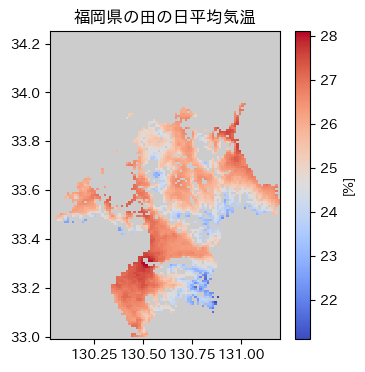

In [ ]:
#@title 複数の情報を重ね合わせて表示
#県域記号一覧を作成
kenlist = [['エリアを指定しない','pref_3700',[24.042, 27.892,140.652, 142.073]],
['北海道','pref_0100',[41.350,45.533,139.327,145.998]],
['青森県','pref_0200',[40.217,41.558,139.490,141.685]],
['岩手県','pref_0300',[38.742,40.458,140.652,142.073]],
['宮城県','pref_0400',[37.767,39.008,140.265,141.685]],
['秋田県','pref_0500',[38.867,40.517,139.690,140.998]],
['山形県','pref_0600',[37.733,39.217,139.515,140.648]],
['福島県','pref_0700',[36.783,37.983,139.165,141.048]],
['茨城県','pref_0800',[35.733,36.950,139.690,140.860]],
['栃木県','pref_0900',[36.192,37.158,139.327,140.298]],
['群馬県','pref_1000',[35.983,37.067,138.390,139.673]],
['埼玉県','pref_1100',[35.750,36.292,138.702,139.910]],
['千葉県','pref_1200',[34.892,36.108,139.740,140.885]],
['東京都','pref_1300',[34.675,35.900,138.940,139.923]],
['神奈川県','pref_1400',[35.125,35.675,138.915,139.835]],
['新潟県','pref_1500',[36.733,38.558,137.627,139.898]],
['富山県','pref_1600',[36.267,36.983,136.765,137.773]],
['石川県','pref_1700',[36.067,37.858,136.240,137.373]],
['福井県','pref_1800',[35.342,36.300,135.440,136.835]],
['山梨県','pref_1900',[35.167,35.975,138.177,139.135]],
['長野県','pref_2000',[35.192,37.033,137.315,138.748]],
['岐阜県','pref_2100',[35.133,36.467,136.277,137.660]],
['静岡県','pref_2200',[34.567,35.650,137.465,139.185]],
['愛知県','pref_2300',[34.567,35.425,136.665,137.848]],
['三重県','pref_2400',[33.717,35.258,135.852,136.998]],
['滋賀県','pref_2500',[34.783,35.708,135.765,136.460]],
['京都府','pref_2600',[34.700,35.783,134.852,136.060]],
['大阪府','pref_2700',[34.267,35.058,135.090,135.748]],
['兵庫県','pref_2800',[34.150,35.675,134.252,135.473]],
['奈良県','pref_2900',[33.858,34.783,135.540,136.235]],
['和歌山県','pref_3000',[33.425,34.392,135.002,136.023]],
['鳥取県','pref_3100',[35.050,35.617,133.127,134.523]],
['島根県','pref_3200',[34.300,36.358,131.665,133.398]],
['岡山県','pref_3300',[34.292,35.358,133.265,134.423]],
['広島県','pref_3400',[34.025,35.108,132.027,133.473]],
['山口県','pref_3500',[33.708,34.800,130.765,132.498]],
['徳島県','pref_3600',[33.533,34.258,133.652,134.823]],
['香川県','pref_3700',[34.008,34.567,133.440,134.448]],
['愛媛県','pref_3800',[32.883,34.308,132.002,133.698]],
['高知県','pref_3900',[32.700,33.892,132.477,134.323]],
['福岡県','pref_4000',[32.992,34.250,130.027,131.198]],
['佐賀県','pref_4100',[32.950,33.625,129.727,130.548]],
['長崎県','pref_4200',[31.983,34.733,128.102,130.398]],
['熊本県','pref_4300',[32.092,33.200,129.940,131.335]],
['大分県','pref_4400',[32.708,33.742,130.815,132.185]],
['宮崎県','pref_4500',[31.350,32.842,130.702,131.885]],
['鹿児島県','pref_4600',[28.750,32.317,128.965,131.210]],
['沖縄県','pref_4700',[24.042,27.892,122.927,131.335]]]
#情報名を入力する
#@markdown ###表示する県を選択
県= '福岡県' # @param ["エリアを指定しない","北海道", "青森県", "岩手県", "宮城県", "秋田県", "山形県", "福島県", "茨城県", "栃木県", "群馬県", "埼玉県", "千葉県", "東京都", "神奈川県", "新潟県", "富山県", "石川県", "福井県", "山梨県", "長野県", "岐阜県", "静岡県", "愛知県", "三重県", "滋賀県", "京都府", "大阪府", "兵庫県", "奈良県", "和歌山県", "鳥取県", "島根県", "岡山県", "広島県", "山口県", "徳島県", "香川県", "愛媛県", "高知県", "福岡県", "佐賀県", "長崎県", "熊本県", "大分県", "宮崎県", "鹿児島県", "沖縄県"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in kenlist:
    if 県 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = kenlist.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
ken = kenlist[j][1]
doko = kenlist[j][2]

if 県== 'エリアを指定しない':
  #@markdown ※エリアを指定しない場合は表示区域を選択してください
  小さいほうの緯度 = 33.0 # @param {type:"number"}
  小さいほうの経度 = 130.0 # @param {type:"number"}
  大きいほうの緯度 = 34.0 # @param {type:"number"}
  大きいほうの経度 = 132.0 # @param {type:"number"}

  doko= [小さいほうの緯度,大きいほうの緯度,小さいほうの経度,大きいほうの経度]


#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigou = [['-', 'TMP_mea'],['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['1mm以上の降水の有無', 'OPR'], ['日照時間', 'SSD'], ['全天日射量', 'GSR'], ['下向き長波放射量', 'DLR'], ['日平均相対湿度', 'RH'], ['日平均風速', 'WIND'], ['積雪深', 'SD'], ['積雪相当水量', 'SWE'], ['日降雪相当水量', 'SFW'], ['予報気温の確からしさ', 'PTMP']]
#情報名を入力する
欲しい情報 = '日平均気温' # @param ["-","日平均気温", "日最高気温", "日最低気温", "降水量", "1mm以上の降水の有無", "日照時間", "全天日射量", "下向き長波放射量", "日平均相対湿度", "日平均風速", "積雪深", "積雪相当水量", "日降雪相当水量", "予報気温の確からしさ"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in yousokigou:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigou.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigou[j][1]

#@markdown ###期間の指定

表示する日付= '2024-09-01' # @param {type:"date"}
itsu= [表示する日付, 表示する日付]

#土地利用比率記号一覧を作成
youtilist = [['-','landuse_H210100'],
['田','landuse_H210100'],
['その他の農用地','landuse_H210200'],
['森林','landuse_H210500'],
['荒地','landuse_H210600'],
['建物用地','landuse_H210700'],
['道路','landuse_H210901'],
['鉄道','landuse_H210902'],
['その他の用地','landuse_H211000'],
['河川地及び湖沼','landuse_H211100'],
['海浜','landuse_H211400'],
['海水域','landuse_H211500'],
['ゴルフ場','landuse_H211600']]
#情報名を入力する
#@markdown ###表示する種別を選択
種別= "田" #@param ["-","田", "その他の農用地", "森林", "荒地", "建物用地", "道路", "鉄道", "その他の用地", "河川地及び湖沼", "海浜", "海水域", "ゴルフ場"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in youtilist:
    if 種別 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = youtilist.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
syubetu = youtilist[j][1]


if 県== 'エリアを指定しない':
  # 設定に基づき地理情報を取得
  prf=1
  figname1=str("")
else:
  prf, lat, lon = amd.GetGeoData(ken, doko)
  figname1=str(県+"の")

if 欲しい情報== '-':
  Ta =1
  figname2=str("")
else:
  # 設定に基づき気象データを取得
  data, tim, lat, lon, nam, uni = amd.GetMetData(nani, itsu, doko, namuni=True)
  Ta = data[0,:,:]
  figname2=str(欲しい情報)


if 種別== '-':
  pad =1
  figname3=str("")
else:
  # 分布率データの取得
  lu01, lat, lon, nam, uni = amd.GetGeoData(syubetu, doko, namuni=True)
  figname3=str(種別+"の")
  # 比率が０でないメッシュを抽出
  if 欲しい情報== '-':
    pad =lu01
  else:
    pad = np.where(lu01>0, 1, np.nan)

# 二つの条件の「かつ」で気象データにマスクを掛ける
TaAp = Ta * prf * pad

# 図化
amd.mapfig(TaAp, lat, lon,
        #minmax=[-10,40],
        #figsize=[5,5],
        figtitle=figname1+figname3+figname2,
        barlabel=f'[{uni}]',
        filename=県+'_'+欲しい情報+'_'+種別+'.png',
        cmap='coolwarm')

In [ ]:
#@title 図をダウンロード
files.download(県+'_'+欲しい情報+'_'+種別+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title .CSVファイルでデータをダウンロード
# 列見出しの作成
dates = [d.strftime('%Y-%m-%d') for d in tim]
header = 'メッシュ値, 緯度, 経度, ' + ', '.join(dates)

# CSVファイルへの書き出し
amd.PutCSV_MT(data,lat,lon, addlalo=True, header=header, filename=県+'_'+欲しい情報+'_'+種別+'.csv')

files.download(県+'_'+欲しい情報+'_'+種別+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#6.データの集計

積算〇〇を計算する

GSR (61, 120, 160) Tile


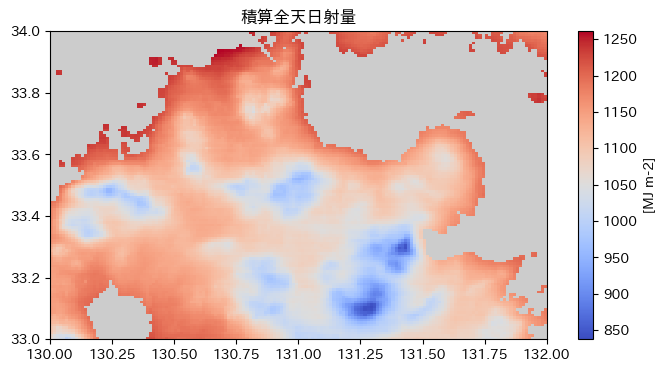

In [ ]:
#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigou = [['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['1mm以上の降水の有無', 'OPR'], ['日照時間', 'SSD'], ['全天日射量', 'GSR'], ['下向き長波放射量', 'DLR'], ['日平均相対湿度', 'RH'], ['日平均風速', 'WIND'], ['積雪深', 'SD'], ['積雪相当水量', 'SWE'], ['日降雪相当水量', 'SFW'], ['予報気温の確からしさ', 'PTMP']]
#情報名を入力する
欲しい情報 = '全天日射量' # @param ["日平均気温", "日最高気温", "日最低気温", "降水量", "1mm以上の降水の有無", "日照時間", "全天日射量", "下向き長波放射量", "日平均相対湿度", "日平均風速", "積雪深", "積雪相当水量", "日降雪相当水量", "予報気温の確からしさ"]
#リスト（情報名）の中から入力した都市名と一致するものを検索する
for i in yousokigou:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigou.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigou[j][1]

#@markdown ###期間の指定

#@markdown ※26日先までの予測が用意されているのは日平均気温、日最高気温、日最低気温、降水量、日照時間、予報気温の確からしさです。そのほかは９日先までの予測が用意されています
初め= '2024-08-01' # @param {type:"date"}
終わり = '2024-09-30' # @param {type:"date"}
itsu= [初め, 終わり]

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
小さいほうの緯度 = 33.0 # @param {type:"number"}
小さいほうの経度 = 130.0 # @param {type:"number"}
大きいほうの緯度 = 34.0 # @param {type:"number"}
大きいほうの経度 = 132.0 # @param {type:"number"}

doko= [小さいほうの緯度,大きいほうの緯度,小さいほうの経度,大きいほうの経度]

# 設定に基づき気象データを取得
data, tim, lat, lon, nam, uni = amd.GetMetData(nani, itsu, doko, namuni=True)

# 日付方向の合計
Ta = data.sum(axis=0)

amd.mapfig(Ta, lat, lon,
        #minmax=[-10,40],
        #figsize=[5,5],
        figtitle="積算"+str(欲しい情報),
        barlabel=f'[{uni}]',
        filename="積算"+欲しい情報+'.png',
        cmap='coolwarm')

In [ ]:
#@title 図をダウンロード
files.download("積算"+欲しい情報+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title .CSVファイルでデータをダウンロード
# 列見出しの作成
dates = [d.strftime('%Y-%m-%d') for d in tim]
header = 'メッシュ値, 緯度, 経度, ' + ', '.join(dates)

# CSVファイルへの書き出し
amd.PutCSV_MT(data,lat,lon, addlalo=True, header=header, filename="積算"+欲しい情報+'.csv')

files.download("積算"+欲しい情報+'.csv')

In [ ]:
#@title 地理院地図と重ね合わせて表示（PCのみ）
#@markdown ←の➤を押してファイルをダウンロード、その中の１つ **.html** をファイルをダブルクリックしてください。

amd.PutGSI_Map(Ta, lat, lon, filename="積算"+欲しい情報)

files.download("積算"+欲しい情報+'.html')
files.download("積算"+欲しい情報+'_l.png')
files.download("積算"+欲しい情報+'_o.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#7.発育の予測

##DVR/DVS法
農業現場で行われる発育予測の殆どは、DVR/DVS法 で行われています。これは、作物や害虫の発育を以下の考え方で予測するものです。良く知られる 有効積算気温法 や三角法 もこれに含まれます。


##到達値を1とする有効積算気温法の DVR 関数
有効積算気温法とは、一定の 基準温度(成長ゼロ点) を超える温度を日々積算し、その値が 固有の積算値(到達積算温度) に達したときに生命現象が起きるとする考え方です。以下に示すのは、基準温度、固有の積算値をパラメータにとり、１となったときに生命現象が生起するとする DVR 関数を Python で記述したものです。

In [ ]:
#@title 例：水稲の出穂日を日平均気温から計算

import datetime

def DVR(Ta, Para=[10.0, 1000.0]):
    '''
    積算温度型の発育速度関数。
    引数(必須)：
      Ta：日平均気温
    引数(必要に応じ設定)
      Para:基準温度(「生長ゼロ点」とも、これ以下の場合積算をしない) と 出穂到達積算温度
    　　　　のリスト。デフォルト値として[10, 1000]が設定されている。
    戻り値：気温に対する発育速度値
    '''
    if Para[0] < Ta:
        DVR = (Ta-Para[0])/Para[1] #（平均気温ー基準温度）/出穂到達積算温度
    else:
        DVR = 0.0
    return DVR

nani = 'TMP_mea'

#@markdown ###期間の指定

移植日= '2024-05-01' # @param {type:"date"}
dt=datetime.datetime.strptime(移植日, '%Y-%m-%d') + datetime.timedelta(days=365)
終わり=dt.strftime('%Y-%m-%d')
itsu= [初め, 終わり]

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
緯度 = 33.6294 # @param {type:"number"}
経度 = 130.667 # @param {type:"number"}

doko= [緯度,緯度,経度,経度]

#@markdown ###基準温度を設定
基準温度 = 10.0 # @param {type:"number"}
積算温度 = 1050.0 # @param {type:"number"}

#温度設定
para = [基準温度, 積算温度]

# 気象データの取得
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)
Ta = data[:,0,0]

# 出穂の計算
DVS = 0.0
for i, Tai in enumerate(Ta):  # iに'日目'が、Taiにi日目の気温が順次渡される
    DVS += DVR(Tai,Para=para)   # i日目(が終わった時)におけるDVS
    #print(i,Tai,DVS)
    if DVS > 1.0 : # DVSが1を超えたら
        break      # ループを終了
# 結果の表示
print('出穂日: ', tim[i])

TMP_mea (274, 1, 1) Tile
出穂日:  2024-09-24 00:00:00


TMP_mea (144, 152, 94) Tile
pref_4000 (152, 94) Tile
landuse_H210100 (152, 94) Tile


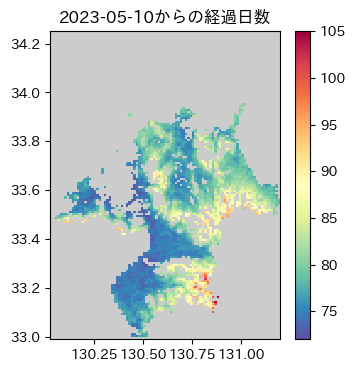

In [ ]:
#@title 例:水稲の出穂日を地図で表示
def DVR(Ta, Para=[10.0, 1000.0]):
    '''
    積算温度型の発育速度関数。
    引数(必須)：
      Ta：日平均気温
    引数(必要に応じ設定)
      Para:基準温度(「生長ゼロ点」とも、これ以下の場合積算をしない) と 出穂到達積算温度
    　　　　のリスト。デフォルト値として[10, 1000]が設定されている。
    戻り値：気温に対する発育速度値
    '''
    if Para[0] < Ta:
        DVR = (Ta-Para[0])/Para[1] #（平均気温ー基準温度）/出穂到達積算温度
    else:
        DVR = 0.0
    return DVR
#県域記号一覧を作成
kenlist = [['エリアを指定しない','pref_3700',[24.042, 27.892,140.652, 142.073]],
['北海道','pref_0100',[41.350,45.533,139.327,145.998]],
['青森県','pref_0200',[40.217,41.558,139.490,141.685]],
['岩手県','pref_0300',[38.742,40.458,140.652,142.073]],
['宮城県','pref_0400',[37.767,39.008,140.265,141.685]],
['秋田県','pref_0500',[38.867,40.517,139.690,140.998]],
['山形県','pref_0600',[37.733,39.217,139.515,140.648]],
['福島県','pref_0700',[36.783,37.983,139.165,141.048]],
['茨城県','pref_0800',[35.733,36.950,139.690,140.860]],
['栃木県','pref_0900',[36.192,37.158,139.327,140.298]],
['群馬県','pref_1000',[35.983,37.067,138.390,139.673]],
['埼玉県','pref_1100',[35.750,36.292,138.702,139.910]],
['千葉県','pref_1200',[34.892,36.108,139.740,140.885]],
['東京都','pref_1300',[34.675,35.900,138.940,139.923]],
['神奈川県','pref_1400',[35.125,35.675,138.915,139.835]],
['新潟県','pref_1500',[36.733,38.558,137.627,139.898]],
['富山県','pref_1600',[36.267,36.983,136.765,137.773]],
['石川県','pref_1700',[36.067,37.858,136.240,137.373]],
['福井県','pref_1800',[35.342,36.300,135.440,136.835]],
['山梨県','pref_1900',[35.167,35.975,138.177,139.135]],
['長野県','pref_2000',[35.192,37.033,137.315,138.748]],
['岐阜県','pref_2100',[35.133,36.467,136.277,137.660]],
['静岡県','pref_2200',[34.567,35.650,137.465,139.185]],
['愛知県','pref_2300',[34.567,35.425,136.665,137.848]],
['三重県','pref_2400',[33.717,35.258,135.852,136.998]],
['滋賀県','pref_2500',[34.783,35.708,135.765,136.460]],
['京都府','pref_2600',[34.700,35.783,134.852,136.060]],
['大阪府','pref_2700',[34.267,35.058,135.090,135.748]],
['兵庫県','pref_2800',[34.150,35.675,134.252,135.473]],
['奈良県','pref_2900',[33.858,34.783,135.540,136.235]],
['和歌山県','pref_3000',[33.425,34.392,135.002,136.023]],
['鳥取県','pref_3100',[35.050,35.617,133.127,134.523]],
['島根県','pref_3200',[34.300,36.358,131.665,133.398]],
['岡山県','pref_3300',[34.292,35.358,133.265,134.423]],
['広島県','pref_3400',[34.025,35.108,132.027,133.473]],
['山口県','pref_3500',[33.708,34.800,130.765,132.498]],
['徳島県','pref_3600',[33.533,34.258,133.652,134.823]],
['香川県','pref_3700',[34.008,34.567,133.440,134.448]],
['愛媛県','pref_3800',[32.883,34.308,132.002,133.698]],
['高知県','pref_3900',[32.700,33.892,132.477,134.323]],
['福岡県','pref_4000',[32.992,34.250,130.027,131.198]],
['佐賀県','pref_4100',[32.950,33.625,129.727,130.548]],
['長崎県','pref_4200',[31.983,34.733,128.102,130.398]],
['熊本県','pref_4300',[32.092,33.200,129.940,131.335]],
['大分県','pref_4400',[32.708,33.742,130.815,132.185]],
['宮崎県','pref_4500',[31.350,32.842,130.702,131.885]],
['鹿児島県','pref_4600',[28.750,32.317,128.965,131.210]],
['沖縄県','pref_4700',[24.042,27.892,122.927,131.335]]]
#情報名を入力する
#@markdown ###表示する県を選択
県= '福岡県' # @param ["エリアを指定しない","北海道", "青森県", "岩手県", "宮城県", "秋田県", "山形県", "福島県", "茨城県", "栃木県", "群馬県", "埼玉県", "千葉県", "東京都", "神奈川県", "新潟県", "富山県", "石川県", "福井県", "山梨県", "長野県", "岐阜県", "静岡県", "愛知県", "三重県", "滋賀県", "京都府", "大阪府", "兵庫県", "奈良県", "和歌山県", "鳥取県", "島根県", "岡山県", "広島県", "山口県", "徳島県", "香川県", "愛媛県", "高知県", "福岡県", "佐賀県", "長崎県", "熊本県", "大分県", "宮崎県", "鹿児島県", "沖縄県"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in kenlist:
    if 県 in i:
        result = True
        break
result
#@markdown ###表示する県を選択
#一致したものがリスト（data）の何行目かを調べる
j = kenlist.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
ken = kenlist[j][1]
doko = kenlist[j][2]

if 県== 'エリアを指定しない':
  #@markdown ※エリアを指定しない場合は表示区域を選択してください
  小さいほうの緯度 = 33.0 # @param {type:"number"}
  小さいほうの経度 = 130.0 # @param {type:"number"}
  大きいほうの緯度 = 34.0 # @param {type:"number"}
  大きいほうの経度 = 132.0 # @param {type:"number"}

  doko= [小さいほうの緯度,大きいほうの緯度,小さいほうの経度,大きいほうの経度]

#@markdown ※水稲なので水田のみのエリアで計算します。

#@markdown 過去の期間で指定する
移植日= '2023-05-10' # @param {type:"date"}
終わり = '2023-09-30' # @param {type:"date"}
itsu= [移植日, 終わり]

#@markdown ###基準温度を設定
基準温度 = 10.0 # @param {type:"number"}
積算温度 = 1050.0 # @param {type:"number"}


nani = 'TMP_mea'

# 気象データの取得
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)

if 県== 'エリアを指定しない':
  # 設定に基づき地理情報を取得
  prf=1
else:
  prf, lat, lon = amd.GetGeoData(ken, doko)

lu01,lat,lon  = amd.GetGeoData('landuse_H210100', doko)
pad = np.where(lu01>0.0, 1, np.nan)  # 田が少しでもあれば1,全くなければ無効値の配列
met = np.where( ~np.isnan(data[0,:,:]), 1, np.nan) # 気象データがあれば１なければ無効値の配列
val = prf * pad * met
yy,xx = np.where(val == 1) # 計算対象のインデックス(要素の番号)

# 出穂日数を記録するための配列を新規作成
hd = val * np.nan  # 手抜きの方法

#温度設定
para = [基準温度, 積算温度]

for Y, X in zip(yy,xx):
    Ta = data[:,Y,X]  # メッシュ[Y,X]における全期間の気温
    #出穂日計算
    DVS = 0.0 #移植時の発育指数
    for i, Tai in enumerate(Ta):  # iに'日目'、Taiにi日目の気温が順次渡される
        DVS += DVR(Tai,Para=para)   # i日目(が終わった時)におけるDVS
        if DVS > 1.0 : #DVSが1を超えたら
            break
    hd[Y,X] = i


amd.mapfig(hd, lat, lon,
        figtitle=移植日+'からの経過日数')

In [ ]:
#@title .CSVファイルでデータをダウンロード
# 列見出しの作成
dates = [d.strftime('%Y-%m-%d') for d in tim]
header = 'メッシュ値, 緯度, 経度, ' + ', '.join(dates)

# CSVファイルへの書き出し
amd.PutCSV_MT(hd,lat,lon, addlalo=True, header=header, filename=移植日+'からの経過日数.csv')

files.download(移植日+'からの経過日数.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title 地理院地図と重ね合わせて表示(PCのみ)
#@markdown ←の➤を押してファイルをダウンロード、その中の１つ **.html** をファイルをダブルクリックしてください。
# 地理院地図上に表示するファイルの作成
amd.PutGSI_Map(hd, lat, lon,
               label=移植日+'からの経過日数',
               filename=str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_発育予測')


files.download(str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_発育予測'+'.html')
files.download(str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_発育予測'+'_l.png')
files.download(str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_発育予測'+'_o.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##発育の分布図（三角法）

気温は時刻により変動するので、日平均気温としては基準温度(成長ゼロ点)を下回っていても、昼間の数時間はそれを上回るような状況は普通に起こります。有効積算気温法におけるパラメータはこのような状況も織り込んで定められますが、発育速度が温度帯によって明瞭に異なる昆虫等では、"状況を織り込む" やり方ではなかなか精度よく推定ができません。
精度を向上させるには時別気温等、時間分解能が高い気象データを使用することが最も合理的ですが、メッシュ農業気象データが提供する時別気温は９日先までなので、これを超える未来について予測をするときには、日別気象データでの予測が求められます。このようなときには、三角法 (坂神・是永 1981)を利用するのが次善の策として適切です。三角法は、気温の時別値がそう簡単には入手できなかった時代に開発された方法で、気温の日変化が０時の日最低気温、8時の日最高気温、24時の翌日の日最低気温を結ぶ折れ線の形で起きると仮定し、生物毎に定められた 発育下限温度、発育上限温度、発育停止温度 がこの折れ線を三角形や台形で切り取る部分の面積を積算するものです。

###例:ヒメトビウンカの防除タイミング予想
ヒメトビウンカという昆虫は、水稲の主要な病害の一つであるイネ縞葉枯病を媒介することから適切に防除する必要があります。薬剤が最も効果的に作用するのは孵化直後の1齢幼虫に対してですが、薬剤効果の持続期間も考慮し、営農上の適期は、卵として生み出された直後から1齢幼虫終了までの間とされます。なお、関東地方において、ヒメトビウンカは4齢幼虫で越冬するので、このような防除適期（要防除期）は2回存在します。１回目の開始は、第4齢で越冬に入った個体(第１世代)が成長して産卵(第２世代)したとき、２回目は、この第２世代が成長して産卵(第３世代)したときです。

　以下にヒメトビウンカの発育に関するデータを示します。

三角法に必要なパラメータ

発育ゼロ点(k1: これを下回る温度では成長しない) 11.0℃

発育上限(k2: この温度で成長速度は頭打ちとなる) 29.0℃

発育停止(k3: これを上回る温度では成長しない) 30.2℃

TMP_min (242, 120, 160) Tile
TMP_max (242, 120, 160) Tile
landuse_H210100 (120, 160) Tile


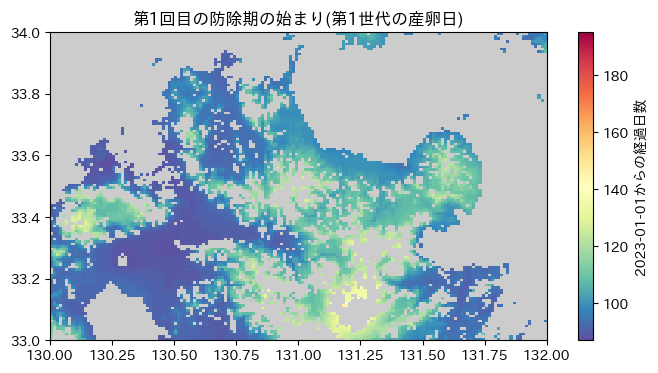

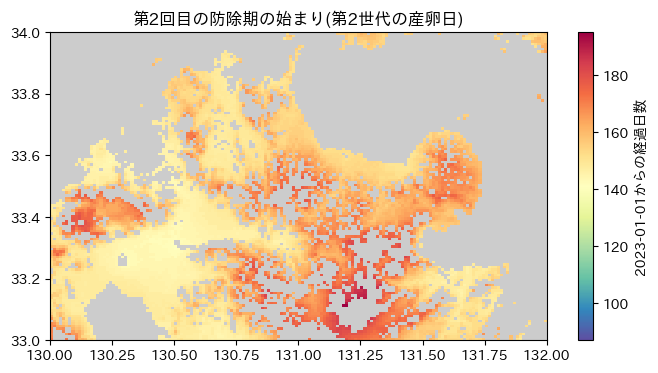

In [ ]:
#県域記号一覧を作成
kenlist = [['エリアを指定しない','pref_3700',[24.042, 27.892,140.652, 142.073]],
['北海道','pref_0100',[41.350,45.533,139.327,145.998]],
['青森県','pref_0200',[40.217,41.558,139.490,141.685]],
['岩手県','pref_0300',[38.742,40.458,140.652,142.073]],
['宮城県','pref_0400',[37.767,39.008,140.265,141.685]],
['秋田県','pref_0500',[38.867,40.517,139.690,140.998]],
['山形県','pref_0600',[37.733,39.217,139.515,140.648]],
['福島県','pref_0700',[36.783,37.983,139.165,141.048]],
['茨城県','pref_0800',[35.733,36.950,139.690,140.860]],
['栃木県','pref_0900',[36.192,37.158,139.327,140.298]],
['群馬県','pref_1000',[35.983,37.067,138.390,139.673]],
['埼玉県','pref_1100',[35.750,36.292,138.702,139.910]],
['千葉県','pref_1200',[34.892,36.108,139.740,140.885]],
['東京都','pref_1300',[34.675,35.900,138.940,139.923]],
['神奈川県','pref_1400',[35.125,35.675,138.915,139.835]],
['新潟県','pref_1500',[36.733,38.558,137.627,139.898]],
['富山県','pref_1600',[36.267,36.983,136.765,137.773]],
['石川県','pref_1700',[36.067,37.858,136.240,137.373]],
['福井県','pref_1800',[35.342,36.300,135.440,136.835]],
['山梨県','pref_1900',[35.167,35.975,138.177,139.135]],
['長野県','pref_2000',[35.192,37.033,137.315,138.748]],
['岐阜県','pref_2100',[35.133,36.467,136.277,137.660]],
['静岡県','pref_2200',[34.567,35.650,137.465,139.185]],
['愛知県','pref_2300',[34.567,35.425,136.665,137.848]],
['三重県','pref_2400',[33.717,35.258,135.852,136.998]],
['滋賀県','pref_2500',[34.783,35.708,135.765,136.460]],
['京都府','pref_2600',[34.700,35.783,134.852,136.060]],
['大阪府','pref_2700',[34.267,35.058,135.090,135.748]],
['兵庫県','pref_2800',[34.150,35.675,134.252,135.473]],
['奈良県','pref_2900',[33.858,34.783,135.540,136.235]],
['和歌山県','pref_3000',[33.425,34.392,135.002,136.023]],
['鳥取県','pref_3100',[35.050,35.617,133.127,134.523]],
['島根県','pref_3200',[34.300,36.358,131.665,133.398]],
['岡山県','pref_3300',[34.292,35.358,133.265,134.423]],
['広島県','pref_3400',[34.025,35.108,132.027,133.473]],
['山口県','pref_3500',[33.708,34.800,130.765,132.498]],
['徳島県','pref_3600',[33.533,34.258,133.652,134.823]],
['香川県','pref_3700',[34.008,34.567,133.440,134.448]],
['愛媛県','pref_3800',[32.883,34.308,132.002,133.698]],
['高知県','pref_3900',[32.700,33.892,132.477,134.323]],
['福岡県','pref_4000',[32.992,34.250,130.027,131.198]],
['佐賀県','pref_4100',[32.950,33.625,129.727,130.548]],
['長崎県','pref_4200',[31.983,34.733,128.102,130.398]],
['熊本県','pref_4300',[32.092,33.200,129.940,131.335]],
['大分県','pref_4400',[32.708,33.742,130.815,132.185]],
['宮崎県','pref_4500',[31.350,32.842,130.702,131.885]],
['鹿児島県','pref_4600',[28.750,32.317,128.965,131.210]],
['沖縄県','pref_4700',[24.042,27.892,122.927,131.335]]]
#情報名を入力する
#@markdown ###表示する県を選択
県= 'エリアを指定しない' # @param ["エリアを指定しない","北海道", "青森県", "岩手県", "宮城県", "秋田県", "山形県", "福島県", "茨城県", "栃木県", "群馬県", "埼玉県", "千葉県", "東京都", "神奈川県", "新潟県", "富山県", "石川県", "福井県", "山梨県", "長野県", "岐阜県", "静岡県", "愛知県", "三重県", "滋賀県", "京都府", "大阪府", "兵庫県", "奈良県", "和歌山県", "鳥取県", "島根県", "岡山県", "広島県", "山口県", "徳島県", "香川県", "愛媛県", "高知県", "福岡県", "佐賀県", "長崎県", "熊本県", "大分県", "宮崎県", "鹿児島県", "沖縄県"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in kenlist:
    if 県 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = kenlist.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
ken = kenlist[j][1]
doko = kenlist[j][2]

if 県== 'エリアを指定しない':
  #@markdown ※エリアを指定しない場合は表示区域を選択してください
  小さいほうの緯度 = 33.0 # @param {type:"number"}
  小さいほうの経度 = 130.0 # @param {type:"number"}
  大きいほうの緯度 = 34.0 # @param {type:"number"}
  大きいほうの経度 = 132.0 # @param {type:"number"}

  doko= [小さいほうの緯度,大きいほうの緯度,小さいほうの経度,大きいほうの経度]
#@markdown ※水稲なので水田のみのエリアで計算します。
#@markdown ###期間の指定

#@markdown 過去の期間で指定する
初め= '2023-01-01' # @param {type:"date"}
終わり = '2023-08-30' # @param {type:"date"}
itsu= [初め, 終わり]


# 気象データの取得
datatn, tim, lat, lon = amd.GetMetData('TMP_min', itsu, doko)
datatx, tim, lat, lon = amd.GetMetData('TMP_max', itsu, doko)

#田んぼの位置を取得
lu01,lat,lon  = amd.GetGeoData('landuse_H210100', doko)
pad = np.where(lu01>0.0, 1, np.nan)  # 田が少しでもあれば1,全くなければ無効値の配列
met = np.where( ~np.isnan(datatn[0,:,:]), 1, np.nan) # 気象データがあれば１なければ無効値の配列

if 県== 'エリアを指定しない':
  val =pad * met
else:
  # 設定に基づき地理情報を取得
  prf, lat, lon = amd.GetGeoData(ken, doko)
  val = prf * pad * met
yy,xx = np.where(val == 1) # 計算対象のインデックス(要素の番号)


# 産卵日を記録する配列を手抜きで作成
g1spw = val * np.nan  # 第1世代の産卵日
g2spw = val * np.nan  # 第2世代の産卵日

import numpy as np
def DVR3(Tmin, Tminn, Tmax, k1=10.0, k2=25.0, k3=99.0):
    '''
    生物の発育を三角法(坂神・是永:1981)から推定する方法
    Tmin: ある日の最低気温
    Tminn: 翌日の最低気温
    Tmax: ある日の最高気温
    k1: 発育下限温度（celsius度）
    k2: 発育上限温度（celsius度）
    k3: 発育停止温度（celsius度）
    '''
    div = 12 # 解析的な方法に近づけたい場合はこの値を大きくする
    h = np.zeros(24*div)
    h[:8*div] = np.linspace(Tmin, Tmax, 8*div,endpoint=False)
    h[8*div:] = np.linspace(Tmax, Tminn, (24-8)*div)
    h = np.where(h>=k3, k1, h)
    h = h.clip(k1, k2) - k1
    return h.sum()/(24*div)

#@markdown ###基準温度を設定
発育下限温度 = 10.0 # @param {type:"number"}
発育上限温度 = 25.0 # @param {type:"number"}
発育停止温度 = 99.0 # @param {type:"number"}

# 発育の計算
for Y, X in zip(yy,xx):
    #第1世代の発育
    Tmin = datatn[:,Y,X]  # メッシュ[Y,X]における全期間のデータ
    Tmax = datatx[:,Y,X]  # 　　　　〃
    DVS = 218.6  # 卵→4齢幼虫は終わっている
    for t in range(len(Tmin)-1):  # 翌日の最低気温が取得データからはみ出さないよう１小さくしておく
        DVS += DVR3(Tmin[t],Tmin[t+1],Tmax[t], k1=発育下限温度, k2=発育上限温度, k3=発育停止温度)   # i日目(が終わった時)におけるDVS
        if DVS > 374.3 : #卵から卵のDVS
            break
    g1spw[Y,X] = t
    #第2世代の発育
    Tmin = datatn[t+1:,Y,X]  # メッシュ[Y,X]における産卵日翌日以降のデータ
    Tmax = datatx[t+1:,Y,X]  # 　　　　〃
    DVS = 0  # 卵からなので0スタート
    for t in range(len(Tmin)-1):  # jは産卵翌日からの日数(ゼロ始まり)'、Taiはj日目の気温
        DVS += DVR3(Tmin[t],Tmin[t+1],Tmax[t], k1=11.0, k2=29.0, k3=30.2)   # i日目(が終わった時)におけるDVS
        if DVS > 374.3 : #卵から卵のDVS
            break
    g2spw[Y,X] = g1spw[Y,X] + t + 1

# 予測結果の描画
mima = [np.nanmin(g1spw),np.nanmax(g2spw)]  # カラーバーの最小値、最大値
amd.mapfig(g1spw, lat, lon, minmax=mima, figtitle='第1回目の防除期の始まり(第1世代の産卵日)', barlabel=初め+'からの経過日数')
amd.mapfig(g2spw, lat, lon, minmax=mima, figtitle='第2回目の防除期の始まり(第2世代の産卵日)', barlabel=初め+'からの経過日数')

amd.PutGSI_Map(g1spw, lat, lon,
               label=初め+'からの経過日数',
               filename=str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_第1世代防除予測')
amd.PutGSI_Map(g2spw, lat, lon,
               label=初め+'からの経過日数',
               filename=str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_第2世代防除予測')

In [ ]:
#@title 地理院地図と重ね合わせて表示（PCのみ）
#@markdown ←の➤を押してファイルをダウンロード、その中の１つ **.html** をファイルをダブルクリックしてください。


amd.PutGSI_Map(g1spw, lat, lon,
               label=初め+'からの経過日数',
               filename=str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_第1回目の防除期の始まり(第1世代の産卵日)')
amd.PutGSI_Map(g2spw, lat, lon,
               label=初め+'からの経過日数',
               filename=str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_第2回目の防除期の始まり(第1世代の産卵日)')


files.download(str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_第1回目の防除期の始まり(第1世代の産卵日)'+'.html')
files.download(str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_第1回目の防除期の始まり(第1世代の産卵日)'+'_l.png')
files.download(str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_第1回目の防除期の始まり(第1世代の産卵日)'+'_o.png')

files.download(str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_第2回目の防除期の始まり(第1世代の産卵日)'+'.html')
files.download(str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_第2回目の防除期の始まり(第1世代の産卵日)'+'_l.png')
files.download(str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'_第2回目の防除期の始まり(第1世代の産卵日)'+'_o.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##引用
このノートブックには[農研機構メッシュ農業気象データThe Agro-Meteorological Grid Square Data, NARO大野ら、2016](https://amu.rd.naro.go.jp/)を利用した。

##文献
● 大野宏之、佐々木華織、大原源二、中園　江、2016：実況値と数値予報、平年値を組み合わせたメッシュ気温・降水量データの作成. 生物と気象、16、71-79．

● 佐々木華織、西森基貴、根本　学、2022：メッシュ農業気象データ利用マニュアルVer.5．農研機構、77pp．